# Evaluate a Pre-Trained Segmentation Model on WHERD

Demonstrates image pre-processing, prediction and validation statistics. But first, some preliminaries...

__Note:__ To maintain a high priority Colab user status such that sufficient GPU resources are available in the future, ensure to free the runtime when finished running this notebook. This can be done using 'Runtime > Manage Sessions' and click 'Terminate'.

In [1]:
# Check if notebook is running in Colab or local workstation
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
    !pip install gputil
    !pip install psutil
    !pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

try:
    # XXX: only one GPU on Colab and isn’t guaranteed
    gpu = GPUs[1]
    def printm():
        process = psutil.Process(os.getpid())
        print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
        print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
    printm() 

    # Check if GPU capacity is sufficient to proceed
    if gpu.memoryFree < 10000:
        print("\nInsufficient memory! Some cells may fail. Please try restarting the runtime using 'Runtime → Restart Runtime...' from the menu bar. If that doesn't work, terminate this session and try again later.")
    else:
        print('\nGPU memory is sufficient to proceeed.')
except:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')

Gen RAM Free: 66.2 GB  | Proc size: 54.1 MB
GPU RAM Free: 11176MB | Used: 2MB | Util   0% | Total 11178MB

GPU memory is sufficient to proceeed.


In [2]:
if IN_COLAB:

    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = r'/content/drive/My Drive/Data'
    
    # cd into git repo so python can find utils
    %cd '/content/drive/My Drive/cciw-zebra-mussel/predict'

    sys.path.append('/content/drive/My Drive')
    
    # clone repo, install packages not installed by default
    !pip install pydensecrf

In [25]:
import os
import os.path as osp

import glob

# for manually reading high resolution images
import cv2 as cv
import numpy as np

# for comparing predictions to lab analysis data frames
import pandas as pd

# for plotting
import matplotlib
# enable LaTeX style fonts
matplotlib.rc('text', usetex=True)
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# pytorch core library
import torch
# pytorch neural network functions
from torch import nn
# pytorch dataloader
from torch.utils.data import DataLoader

# for post-processing model predictions by conditional random field 
import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils

from tqdm import tqdm  # progress bar

# evaluation metrics
from sklearn.metrics import r2_score
from sklearn.metrics import jaccard_score as jsc

# local imports (files provided by this repo)
import transforms as T

# various helper functions, metrics that can be evaluated on the GPU
from task_3_utils import evaluate, evaluate_loss, eval_binary_iou, pretty_image

# Custom dataloader for rapidly loading images from a single LMDB file
from folder2lmdb import VOCSegmentationLMDB

# for finding laser beams
from sklearn.cluster import KMeans

In [4]:
"""Confim that this cell prints "Found GPU, cuda". If not, select "GPU" as 
"Hardware Accelerator" under the "Runtime" tab of the main menu.
"""
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Found GPU,', device)

Found GPU, cuda


## 1. Load a pre-trained model checkpoint

In [5]:
os.environ['DATA_PATH'] = '/scratch/gallowaa/'

In [218]:
SEED = 3

if IN_COLAB:
    root = osp.join(
        DATA_PATH, 'Checkpoints/deeplabv3_resnet50_lr1e-01_wd5e-04_bs40_ep80_seed1')
    
else:
    root = osp.join(
        os.environ['DATA_PATH'], 'cciw/logs/cmp-dataset/train_v120/deeplabv3_resnet50/lr1e-01/wd5e-04/bs40/ep80/seed%d/checkpoint' % SEED)
    #root = osp.join(
    #    os.environ['DATA_PATH'], 'cciw/logs/cmp-dataset/deeplab/trainval_v120/deeplabv3_resnet50/lr1e-01/wd5e-04/bs40/ep80/seed1/checkpoint/')

ckpt_file = 'deeplabv3_resnet50_lr1e-01_wd5e-04_bs40_ep80_seed%d_epoch79.ckpt' % SEED
#ckpt_file = 'deeplabv3_resnet50_lr1e-01_wd5e-04_bs40_ep80_seed%d_epoch40.ckpt' % SEED

model_to_load = osp.join(root, ckpt_file)
                         
print('Loading', model_to_load)                         
         
checkpoint = torch.load(model_to_load)
                        
train_loss = checkpoint['trn_loss']
val_loss = checkpoint['val_loss']
print('==> Resuming from checkpoint..')
net = checkpoint['net']
last_epoch = checkpoint['epoch']
torch.set_rng_state(checkpoint['rng_state'])

# later appended to figure filenames
model_stem = ckpt_file.split('.')[0]

print('Loaded model %s trained to epoch ' % model_stem, last_epoch)
print(
    'Cross-entropy loss {:.4f} for train set, {:.4f} for validation set'.format(train_loss, val_loss))

sig = nn.Sigmoid()  # initializes a sigmoid function

net.eval()

Loading /scratch/gallowaa/cciw/logs/cmp-dataset/train_v120/deeplabv3_resnet50/lr1e-01/wd5e-04/bs40/ep80/seed3/checkpoint/deeplabv3_resnet50_lr1e-01_wd5e-04_bs40_ep80_seed3_epoch79.ckpt
==> Resuming from checkpoint..
Loaded model deeplabv3_resnet50_lr1e-01_wd5e-04_bs40_ep80_seed3_epoch79 trained to epoch  79
Cross-entropy loss 0.1598 for train set, 0.9088 for validation set


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
'''
from fcn import FCN8s
net = FCN8s(n_class=1).to(device)

from apex import amp
net = amp.initialize(net, opt_level='O3')
'''

In [7]:
root = osp.join(os.environ['DATA_PATH'], 'cciw/logs/cmp-dataset/train_v120/')
print(root)

#files = glob.glob(root + '*/*/*/*/*/*/checkpoint/*epoch79.ckpt')
files = glob.glob(root + 'deeplab*/*/*/*/*/*/checkpoint/*epoch79.ckpt')

print(len(files))
files

/scratch/gallowaa/cciw/logs/cmp-dataset/train_v120/
3


['/scratch/gallowaa/cciw/logs/cmp-dataset/train_v120/deeplabv3_resnet50/lr1e-01/wd5e-04/bs40/ep80/seed1/checkpoint/deeplabv3_resnet50_lr1e-01_wd5e-04_bs40_ep80_seed1_epoch79.ckpt',
 '/scratch/gallowaa/cciw/logs/cmp-dataset/train_v120/deeplabv3_resnet50/lr1e-01/wd5e-04/bs40/ep80/seed2/checkpoint/deeplabv3_resnet50_lr1e-01_wd5e-04_bs40_ep80_seed2_epoch79.ckpt',
 '/scratch/gallowaa/cciw/logs/cmp-dataset/train_v120/deeplabv3_resnet50/lr1e-01/wd5e-04/bs40/ep80/seed3/checkpoint/deeplabv3_resnet50_lr1e-01_wd5e-04_bs40_ep80_seed3_epoch79.ckpt']

In [ ]:
if IN_COLAB:
    root = osp.join(DATA_PATH, 'Checkpoints/fcn8slim_lr1e-03_wd5e-04_bs32_ep50_seed1')
else:
    pass
    #root = '/scratch/gallowaa/cciw/logs/v1.0.1-debug/fcn8s/lr1e-03/wd5e-04/bs25/ep80/seed4/checkpoint' # b
    #root = '/scratch/gallowaa/cciw/logs/v111/trainval/fcn8s/lr1e-03/wd5e-04/bs40/ep80/seed2/checkpoint/' # d

#ckpt_file = 'fcn8s_lr1e-03_wd5e-04_bs25_ep80_seed4_epoch70.ckpt' # b
#ckpt_file = 'fcn8s_lr1e-03_wd5e-04_bs40_ep80_seed2amp_epoch79.pt' # d

"""Feel free to try these other checkpoints later after running epoch40 to get a 
feel for how the evaluation metrics change when model isn't trained as long."""

#checkpoint = torch.load(osp.join(root, ckpt_file))
f = 2
checkpoint = torch.load(files[f])
train_loss = checkpoint['trn_loss']
val_loss = checkpoint['val_loss']
print('==> Resuming from checkpoint..')

net = checkpoint['net']
'''
# AMP
net.load_state_dict(checkpoint['net'])
amp.load_state_dict(checkpoint['amp'])
'''
last_epoch = checkpoint['epoch'] + 1
torch.set_rng_state(checkpoint['rng_state'])

# later appended to figure filenames
#model_stem = ckpt_file.split('.')[0]
model_stem = files[f].split('/')[-1].split('.')[0]

print('Loaded model %s trained to epoch ' % model_stem, last_epoch)
print('Cross-entropy loss {:.4f} for train set, {:.4f} for validation set'.format(train_loss, val_loss))

net.eval()

In [ ]:
#net = amp.initialize(net, opt_level='O3')

In [7]:
sig = nn.Sigmoid()  # initializes a sigmoid function

## 7. i) Visualize Predictions on Whole Images

Here we manually load and preprocess the original images and png masks using OpenCV.

`root_path` -- will also be used in 

In [8]:
if IN_COLAB:
    root_path = osp.join(DATA_PATH, 'ADIG_Labelled_Dataset/Test/Lab/')
else:
    root_path = '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/'
    
jpeg_files = glob.glob(root_path + '*.jpg')
png_files = glob.glob(root_path + '*_final.png')

jpeg_files.sort()
png_files.sort()

# Both should equal 16 for all WHERD dataset
print(len(jpeg_files)) 
print(len(png_files))

16
16


In [9]:
jpeg_files

['/scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_1353_2019-10-30_GoPro-8.jpg',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_1355_2019-10-30_GoPro-5.jpg',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_FS1355_2019-11-03_FishSens-1.jpg',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_FSHP131642_2019-11-03_FishSens-4.jpg',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_FSHP131645_2019-11-03_FishSens-6.jpg',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_FSHP131649_2019-11-03_FishSens-2.jpg',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_FSLEE06022_2019-11-03_FishSens-1.jpg',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_FSLEE06037_2019-11-03_FishSens-1.jpg',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_HP115410_2019-10-30_GoPro-3.jpg',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_HP131641_2019-11-03_GoPro-13.jpg',
 '/scratch/ssd/gallow

In [10]:
"""Set to True to save the model predictions in PNG format, 
otherwise proceed to predict biomass without saving images"""
PLOT = False
SAVE_PREDICTIONS = False

if SAVE_PREDICTIONS:
    prediction_path = ''
    for t in model_to_load.split('/')[:-1]:
    #for t in files[f].split('/')[:-1]:
        prediction_path += t + '/'

    prediction_path = osp.join(prediction_path, 'WHERD')

    if not osp.exists(prediction_path):
        os.mkdir(prediction_path)

    print(prediction_path)
    
    # src is the training dataset, tgt is the testing dataset
    src = 'train_v120'
    tgt = 'WHERD'

In [11]:
fontsize = 16

left = 0.02  # the left side of the subplots of the figure
right = 0.98   # the right side of the subplots of the figure
bottom = 0.05  # the bottom of the subplots of the figure
top = 0.95     # the top of the subplots of the figure
wspace = 0.15  # the amount of width reserved for space between subplots,
# expressed as a fraction of the average axis width
hspace = 0.1  # the amount of height reserved for space between subplots,
# expressed as a fraction of the average axis height

In [12]:
from task_3_utils import img_to_nchw_tensor

In [119]:
search_scales = np.array([157,  # 1353
                          65,  # 1355
                          33,  # FS1355
                          40,  # FSHP131642
                          37,  # FSHP131645
                          100,  # FSHP131649 (55-115)
                          23,  # FSLEE06022
                          80,  # FSLEE06037 (40, 80, 110)
                          125,  # HP115410
                          100,  # HP131641
                          150,  # LEE06021
                          32,  # LEE06031 # (30-32, 60, 130)
                          100,  # LEE06032
                          100,  # LEE06033
                          100,  # LEE06070
                          60])  # LEE06075

In [207]:
for i in range(len(search_scales)):
    print(search_scales[i])

157
65
33
40
37
100
23
80
125
100
150
32
100
100
100
60


In [214]:
# line search for optimal scale
i = 6
scales = np.arange(20, 150, 5)
#scales = np.arange(30, 65, 1)
image_stem = jpeg_files[i].split('/')[-1].split('.')[0]
bgr_lab = cv2.imread(osp.join(root_path, png_files[i]))
bgr_img = cv2.imread(osp.join(root_path, jpeg_files[i]))
labc = cv2.cvtColor(bgr_lab, cv2.COLOR_BGR2RGB)
imgc = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

print(image_stem.split('_')[1])
for scale_percent in scales:
    
    img = resize(imgc, scale_percent)
    lab = resize(labc, scale_percent)
    
    nchw_tensor = img_to_nchw_tensor(img, device)
    with torch.no_grad():
        pred = sig(net(nchw_tensor)['out'])
    pred_np = pred.detach().cpu().numpy()
    mask = np.zeros((lab.shape[0], lab.shape[1]), dtype='float32')
    mask[lab[:, :, 0] == 128] = 1
    pred_np = pred_np.squeeze()
    targets = torch.LongTensor(mask)
    targets = targets.to(device)
    iou = eval_binary_iou(pred, targets).item()
    print(scale_percent, iou)

FSLEE06022
20 0.309807151556015
25 0.3077235817909241
30 0.1907651275396347
35 0.14062562584877014
40 0.09385527670383453
45 0.07593048363924026
50 0.054370611906051636
55 0.02905425988137722
60 0.0057550836354494095
65 0.010719843208789825
70 0.01070113480091095
75 0.00012910444638691843
80 0.0032458724454045296
85 0.007925771176815033
90 0.006963593885302544
95 0.011155098676681519
100 0.010659490711987019
105 0.025866156443953514
110 0.05109870806336403
115 0.040722284466028214
120 0.044854581356048584
125 0.058491963893175125
130 0.05969184637069702
135 0.07352831959724426
140 0.08691459894180298
145 0.08673032373189926


# Find laser beams in image

In [58]:
# meta-parameters for algorithm to find two red laser dots
# red_threshold is out of 255, match_threshold out of 1.0 for template matching
# red_threshold, match_threshold = 200, 0.2 # 10 correct
intensity_threshold, match_threshold = 150, 0.3  # 10

"""C - Constant subtracted from the mean or weighted mean (see the details below). 
Normally, it is positive but may be zero or negative as well."""
C = -15

"""Block size - Size of a pixel neighborhood that is used to calculate a threshold 
value for the pixel: 3, 5, 7, and so on."""
block_size = 201

# noise removing kernel
kernel = np.ones((5, 5), np.uint8)
dilate_kernel = np.ones((6, 6), np.uint8)

j = 0
laser_distances = []

for i in range(len(jpeg_files)):
    f = jpeg_files[i]
    #if f.split('/')[-1] in include_list:
    im = cv.imread(f)
    print(im.shape)
    #outfile = os.path.join(save_path, f.split('/')[-1])

    im = cv.imread(f)  # im will be in BGR format
    im_thresh = im.copy()

    im_ycrbc = cv.cvtColor(im, cv.COLOR_BGR2YCrCb)

    Y  = im_ycrbc[:, :, 0] # Separate pixel intensity Y from 
    Cr = im_ycrbc[:, :, 1] # red-difference chroma 
    Cb = im_ycrbc[:, :, 2] # blue-difference components

    im_thresh[Cr < intensity_threshold] = 0

    cts, bin_edges = np.histogram(im_ycrbc[:, :, 2])
    red_range = bin_edges.max() - bin_edges.min()

    Cr_th = cv.adaptiveThreshold(
        Cr, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 201, C)

    # morphology and connected components
    opening = cv.morphologyEx(Cr_th, cv.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv.dilate(opening, dilate_kernel, iterations=3)

    # Marker labelling
    ret, markers = cv.connectedComponents(sure_bg)

    # get the cluster IDs and number of pixels in each
    ids, cts = np.unique(markers, return_counts=True)

    # only keep the largest two clusters by pixel count
    largest_blobs = ids[1:][np.argsort(cts[1:])][-2:]

    if len(largest_blobs) == 2:
        mask = markers == largest_blobs[0]
        mask |= markers == largest_blobs[1]
        markers[np.invert(mask)] = 0

    # we can now encode clusters with the same value as
    # they should be physically separated
    markers[markers > 0] = 1

    # get numpy array of coordinates of non-zero elements
    coords = cv.findNonZero(markers.astype('uint8'))

    if coords is not None:
        kmeans = KMeans(n_clusters=2, random_state=0).fit(coords.squeeze())
        # draw the two clusters
        for pt in kmeans.cluster_centers_:
            _ = cv.circle(im, (int(pt[0]), int(pt[1])), 50, (0, 255, 0), 2)

        # compute the distance in pixels between the two laser beams
        d = np.linalg.norm(
            kmeans.cluster_centers_[0] - kmeans.cluster_centers_[1])
    else:
        d = -1  # do not change scale if -1
    
    laser_distances.append(d)
    '''
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    title_str = '%d Ratio %.3f - dots are dist %d of %d px' % (j, d/im.shape[1], d, im.shape[1])
    ax.imshow(im)
    ax.set_title(title_str)
    plt.show()
    '''
    j += 1

(1080, 1920, 3)
(1080, 1920, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)


In [61]:
jpeg_file_resolutions = []
for i in range(len(jpeg_files)):
    jpeg_file_resolutions.append(np.prod(cv.imread(jpeg_files[i]).shape[:2]))

In [184]:
laser_distances = np.round(np.asarray(laser_distances), 3)
#mask = laser_distances > 0
#lasers = laser_distances[mask]
lasers = laser_distances / laser_distances.max()
lasers

array([ 0.61158741,  0.76348841,  0.71747365,  0.87254581,  0.4749003 ,
        0.61373774,  1.        ,  0.78011089,  0.5597033 ,  0.74120516,
        0.54149451,  0.58806742,  0.65102339,  0.51385305, -0.00146881,
        0.62179415])

In [185]:
jpeg_file_resolutions = np.asarray(jpeg_file_resolutions)
jpeg_file_resolutions = jpeg_file_resolutions / float(jpeg_file_resolutions.max())
res = jpeg_file_resolutions.copy()#[mask]

In [188]:
# divide by the resolution so that less resolution = larger distance
d = 1 / (lasers / res)
d = d / d.max()

In [192]:
np.round(d, 2)*100

array([ 8.4000e+01,  6.7000e+01,  3.2000e+01,  2.6000e+01,  4.8000e+01,
        3.7000e+01,  2.3000e+01,  2.9000e+01,  9.2000e+01,  6.9000e+01,
        9.5000e+01,  8.7000e+01,  7.9000e+01,  1.0000e+02, -3.4984e+04,
        8.3000e+01])

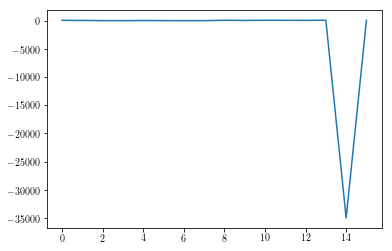

In [190]:
plt.plot(np.round(d, 2)*100)
#plt.plot(search_scales)

In [148]:
search_scales

array([157,  65,  33,  40,  37, 100,  23,  80, 125, 100, 150,  32, 100,
       100, 100,  60])

In [193]:
laser_scales = (d * 100).astype(int)
laser_scales

array([    84,     67,     31,     26,     48,     37,     22,     29,
           91,     69,     94,     87,     78,    100, -34984,     82])

In [222]:
for i in range(len(laser_scales)):
    print(laser_scales[i])

84
67
31
26
48
37
22
29
91
69
94
87
78
100
-34984
82


In [196]:
def resize(image, pct):
    width = int(image.shape[1] * pct / 100)
    height = int(image.shape[0] * pct / 100)
    return cv2.resize(image, (width, height))  # resize image

In [220]:
iou_list = []
#scale_percent = 100

for i in range(len(jpeg_files)):
    image_stem = jpeg_files[i].split('/')[-1].split('.')[0]
    bgr_lab = cv2.imread(osp.join(root_path, png_files[i]))
    bgr_img = cv2.imread(osp.join(root_path, jpeg_files[i]))
    lab = cv2.cvtColor(bgr_lab, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

    scale_percent = laser_scales[i] if laser_scales[i] > 0 else 100
    #scale_percent = search_scales[i]
    img = resize(img, scale_percent)
    lab = resize(lab, scale_percent)

    nchw_tensor = img_to_nchw_tensor(img, device)
    with torch.no_grad():
        pred = sig(net(nchw_tensor)['out'])
    pred_np = pred.detach().cpu().numpy().squeeze()
    mask = np.zeros((lab.shape[0], lab.shape[1]), dtype='float32')
    mask[lab[:, :, 0] == 128] = 1
    
    targets = torch.LongTensor(mask)
    targets = targets.to(device)
    iou = eval_binary_iou(pred, targets).item()
    '''
    p_one_hot, t_one_hot = mask_and_preds_to_1hot(pred_np, mask)

    iou = jsc(p_one_hot.reshape(1, -1),
              t_one_hot.reshape(1, -1), average='samples')
    '''
    iou_list.append(iou)
    print('%d, %.4f' % (i, iou))

    if PLOT:
        # plt.close('all')
        fig, axes = plt.subplots(1, 1, figsize=(19.20, 10.80))
        p = (pred_np * 255).astype('uint8')
        src2 = np.zeros((p.shape[0], p.shape[1], 3), np.uint8)
        src2[:, :, 2] = p
        dst = cv2.addWeighted(img, 0.5, src2, 0.5, 0)
        axes.imshow(dst)
        axes.axis('off')
        plt.tight_layout()
    if SAVE_PREDICTIONS:
        filename = src + '__' + image_stem + '__' + model_stem + \
            '_scale%d_iou_%.4f' % (scale_percent, iou)
        out_file = osp.join(prediction_path, filename)
        fig.savefig(out_file + '.jpg', format='jpeg')
        
print("Average ", np.round(np.asarray(iou_list).mean(), 4))

0, 0.2295
1, 0.4012
2, 0.2567
3, 0.0000
4, 0.0625
5, 0.0000
6, 0.2596
7, 0.3466
8, 0.2484
9, 0.4125
10, 0.3448
11, 0.2050
12, 0.2353
13, 0.0205
14, 0.0000
15, 0.2125
Average  0.2022


In [167]:
iou = jsc(p_one_hot.reshape(1, -1),
          t_one_hot.reshape(1, -1), average='samples')

In [ ]:
0 0.3349668479370011
1 0.2730633762824413
2 0.08701870141603765
3 0.6963940582031034
4 0.7138648992434893
5 0.2700486397208539
6 0.6887657497196386
7 0.943557536979472
8 0.42190770560009877
9 0.8012735566943816
10 0.9509239510349701
11 0.9770874858352112
12 0.8296693915528675
13 0.44408103316978087
14 0.9843869248270862
15 0.8617212302299858
mean 0.6424206930279013

In [152]:
def mask_and_preds_to_1hot(p, y):
    
    # labels y to one hot encoding
    y_1hot = np.zeros((2, y.shape[0], y.shape[1]))
    y_1hot[1, :, :][y == 1] = 1
    y_1hot[0, :, :][y == 0] = 1

    # predictions p to one hot encoding
    p_1hot = np.zeros((2, p.shape[0], p.shape[1]))
    p_1hot[1, :, :][p.squeeze().round() == 1] = 1
    p_1hot[0, :, :][p.squeeze().round() == 0] = 1
    
    return p_1hot, y_1hot

# LOM: Figure 5

In [ ]:
i = 4

image_stem = jpeg_files[i].split('/')[-1].split('.')[0]
bgr_lab = cv2.imread(osp.join(root_path, png_files[i]))
bgr_img = cv2.imread(osp.join(root_path, jpeg_files[i]))
lab = cv2.cvtColor(bgr_lab, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)


scale_percent = 38
#for scale_percent in scales:
width = int(imgc.shape[1] * scale_percent / 100)
height = int(imgc.shape[0] * scale_percent / 100)
img = cv2.resize(imgc, (width, height)) # resize image
lab = cv2.resize(labc, (width, height)) # resize image

nchw_tensor = img_to_nchw_tensor(img, device)

with torch.no_grad():
    pred = sig(net(nchw_tensor)['out'])

pred_np = pred.detach().cpu().numpy().squeeze()

mask = np.zeros((lab.shape[0], lab.shape[1]), dtype='float32')
mask[lab[:, :, 0] == 128] = 1

'''
targets = torch.LongTensor(mask)
targets = targets.to(device)
#print(targets.shape)
iou = eval_binary_iou(pred, targets).item()
'''

p_one_hot, t_one_hot = mask_and_preds_to_1hot(pred_np, mask)

iou = jsc(p_one_hot.reshape(1, -1),
          t_one_hot.reshape(1, -1), average='samples')

#iou_list.append(iou)
print(i, iou)

#if PLOT:

plt.close('all')
fig, axes = plt.subplots(1, 1, figsize=(19.20, 10.80))
p = (pred_np * 255).astype('uint8')
src2 = np.zeros((p.shape[0], p.shape[1], 3), np.uint8)
src2[:, :, 2] = p
dst = cv2.addWeighted(img, 0.75, src2, 0.5, 0)
axes.imshow(dst)
axes.axis('off')
plt.tight_layout()
plt.show()

'''
if SAVE_PREDICTIONS:
    filename = src + '__' + image_stem + '__' + model_stem + '_scale%d_iou_%.4f' % (scale_percent, iou)
    out_file = osp.join(prediction_path, filename)
    fig.savefig(out_file + '.jpg', format='jpeg')
'''

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 1, figsize=(12.80, 7.20))
p = (pred_np * 255).astype('uint8')
src2 = np.zeros((p.shape[0], p.shape[1], 3), np.uint8)
src2[:, :, 2] = p
dst = cv2.addWeighted(img, 0.75, src2, 0.75, 0.25)
axes.imshow(dst)
axes.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
filename = 'fig5-' + src + '-' + tgt + '__' + image_stem + '__' + model_stem
out_file = osp.join(prediction_path, filename)
fig.savefig(out_file + '_scale%d.jpg' % scale_percent)

In [ ]:
scale_percent

In [ ]:
out_file

In [ ]:
pred.shape